<a href="https://colab.research.google.com/github/temiyemi/visual-web-agent/blob/main/08.pyppeteer_roboflow_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Web Agent

A web agent to search for a product on Amazon.com, and add the product to cart.

Agent uses custom Langchain tools, Gemini 1.5 Flash, Pyppeteer, and a trained object detection model on Roboflow.

### Project Setup

Install required dependencies

In [1]:
!pip install -q pyppeteer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00


In [2]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00


In [3]:
!pip install -q langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 9.6 MB/s eta 0:00:00


In [4]:
!pip install -q google-generativeai langchain-google-genai

In [5]:
import asyncio
import json
import os
import uuid

from google.colab import userdata
from pyppeteer import launch, connect
from roboflow import Roboflow

In [6]:
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
ROBOFLOW_WORKSPACE = userdata.get("ROBOFLOW_WORKSPACE")
MODEL_ENDPOINT = userdata.get("MODEL_ENDPOINT")
MODEL_VERSION = userdata.get("MODEL_VERSION")

In [7]:
HOME = os.getcwd()
print(HOME)

try:
  os.mkdir(path=f"{HOME}/screenshots") # for screenshots by pyppeteer
  os.mkdir(path=f"{HOME}/predictions") # for annotated images from roboflow model
except:
  print("screenshots/predictions folders already exist")
  pass

/content


### Object Detection Model Section

In [8]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace(ROBOFLOW_WORKSPACE).project(MODEL_ENDPOINT)
model = project.version(MODEL_VERSION).model

loading Roboflow workspace...
loading Roboflow project...


In [9]:
def get_coordinates(predictions: list[dict]) -> list[dict]:
    """Return a list of x, y, width and height of bounding box coordinates"""

    attrs = ['x', 'y', 'width', 'height']
    return [{k:v for (k,v) in pred.items() if k in attrs} for pred in predictions]

def predict_boundaries(image: str, label: str, confidence: int = 40, overlap: int = 30) -> list[dict]:
    """Make inference for label(s) in the image and return the coordinates object"""

    resp = model.predict(image, classes=label, confidence=confidence, overlap=overlap)
    new_filepath = image.replace('screenshots', 'predictions')
    resp.save(new_filepath) # save the annotated image file
    predictions = resp.json()['predictions']
    if label:
        predictions = list(filter(lambda x: x['class'] == label, predictions))

    return get_coordinates(predictions)


def get_bounding_box(prediction: dict) -> tuple:
    """Calculate and return the top left and bottom right x,y coordinates"""

    x1 = prediction['x'] - prediction['width'] / 2
    y1 = prediction['y'] - prediction['height'] / 2
    x2 = prediction['x'] + prediction['width'] / 2
    y2 = prediction['y'] + prediction['height'] / 2
    return x1, y1, x2, y2


def get_bounding_boxes(predictions: list[dict]) -> list[tuple]:
    """Calculate and return the top left and bottom right x,y coordinates"""

    return list(map(get_bounding_box, predictions))


### Pyppeteer Section

In [10]:
async def click_on(page, coordinate: dict) -> None:
    """Extract and use mouse to click on the x,y coordinate of the page"""

    x = coordinate['x']
    y = coordinate['y']
    await page.mouse.move(x, y)
    await page.mouse.click(x, y)


async def fill_and_submit(page, product_name: str) -> None:
    """Fill product name in the searchbar and submit form"""

    await page.keyboard.type(product_name, options={'delay': 100})
    await page.keyboard.press('Enter')
    await page.waitForNavigation(waitUntil='networkidle2')


async def save_screenshot(page) -> str:
    """Save the screenshot of the page with a unique file name"""

    filename = str(uuid.uuid4())
    filepath = f"{HOME}/screenshots/{filename}.png"
    await page.screenshot(path=filepath)
    return filepath


async def get_browser_connection_url() -> str:
    """Launch the browser instance and only return the websocket endpoint"""

    browser = await launch(
        ignoreHTTPSErrors=True,
        headless=True,
        args=[
            "--no-sandbox",
            "--disable-setuid-sandbox",
            "--disable-gpu",
            "--disable-dev-shm-usage",
            '--proxy-server="direct://"',
            "--proxy-bypass-list=*"
        ],
        autoClose=False
    )

    connectionUrl = browser.wsEndpoint
    await browser.disconnect()
    return connectionUrl


async def get_active_browser_and_page(ws_endpoint: str) -> tuple:
    """Reconnect to existing browser using the websocket endpoint, and
    return the browser instance, and the current active page"""

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    for page in (await browser.pages()):
        await page.bringToFront()

    return browser, page


In [11]:
async def browser_phase_one(product: str) -> tuple:
    """
    Open amazon.com, take a screenshot, make searchbar coordinates inference,
    click on the searchbar coordinate and type in the product name then press submit,
    wait for the search results page to load, take another screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    ws_endpoint = await get_browser_connection_url()

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    page = await browser.newPage()

    # Go to amazon.com homepage
    await page.goto(
        url='https://www.amazon.com',
        options={
            'waitUntil': 'networkidle2',
        }
    )

    screenshot = await save_screenshot(page)

    # make searchbar inference on the screenshot
    coordinates = predict_boundaries(image=screenshot, label='searchbar')

    # the searchbar is always coordinates[0]
    await click_on(page, coordinate=coordinates[0])

    await fill_and_submit(page, product_name=product)

    screenshot = await save_screenshot(page)

    await browser.disconnect()

    return ws_endpoint, screenshot

In [12]:
# Uncomment to test browser_phase_one function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_one(product="braun hair trimmers"), loop)
# future.result()

In [13]:
async def browser_phase_two(ws_endpoint: str, coordinate: dict) -> tuple:
    """
    Re-connect to the browser, and using the existing page, click on the product's
    coordinate and wait for the product detail page to load, then take a screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_on(page, coordinate=coordinate)
    await page.waitForNavigation()

    # scroll page down a bit, in case add to cart button is not in viewport
    await page.evaluate('window.scroll(0, 300)')

    screenshot = await save_screenshot(page)
    # for inference of the add to cart button

    await browser.disconnect()

    return ws_endpoint, screenshot

In [14]:
# Uncomment to test browser_phase_two function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_two(ws_endpoint=""), loop)
# future.result()

In [15]:
async def browser_phase_three(ws_endpoint: str, coordinate: dict) -> tuple:
    """
    Re-connect to the browser, and using the existing page, click on the add to cart
    button coordinate and wait for the next page to load, then take a screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_on(page, coordinate=coordinate)
    await page.waitForNavigation()

    screenshot = await save_screenshot(page)
    # for inference of the view cart button

    await browser.disconnect()

    return ws_endpoint, screenshot

In [16]:
# Uncomment to test browser_phase_three function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_three(ws_endpoint="", coordinate), loop)
# future.result()

### Langchain Tools / Functions

In [17]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool

from IPython.display import Image

In [18]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    google_api_key=GOOGLE_API_KEY,
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE
    },
)

In [19]:
async def product_search_function(product: str) -> tuple:
    """use pyppeteer to browse Amazon.com and search for product"""

    ws_endpoint, screenshot = await browser_phase_one(product=product)
    return ws_endpoint, screenshot

product_search_tool = StructuredTool.from_function(
    coroutine=product_search_function,
    name="ProductSearch",
    description="use this function to search for a product on Amazon.com",
    handle_tool_error=True,
)

[INFO] Starting Chromium download.
INFO:pyppeteer.chromium_downloader:Starting Chromium download.
100%|██████████| 183M/183M [00:01<00:00, 164Mb/s]
[INFO] Beginning extraction
INFO:pyppeteer.chromium_downloader:Beginning extraction
[INFO] Chromium extracted to: /root/.local/share/pyppeteer/local-chromium/1181205
INFO:pyppeteer.chromium_downloader:Chromium extracted to: /root/.local/share/pyppeteer/local-chromium/1181205


ws://127.0.0.1:56107/devtools/browser/c7217165-cbd9-46d5-8fbf-2806169111a5
/content/screenshots/c9ca03ce-5c79-40ab-8b87-6b1ccb2841ca.png


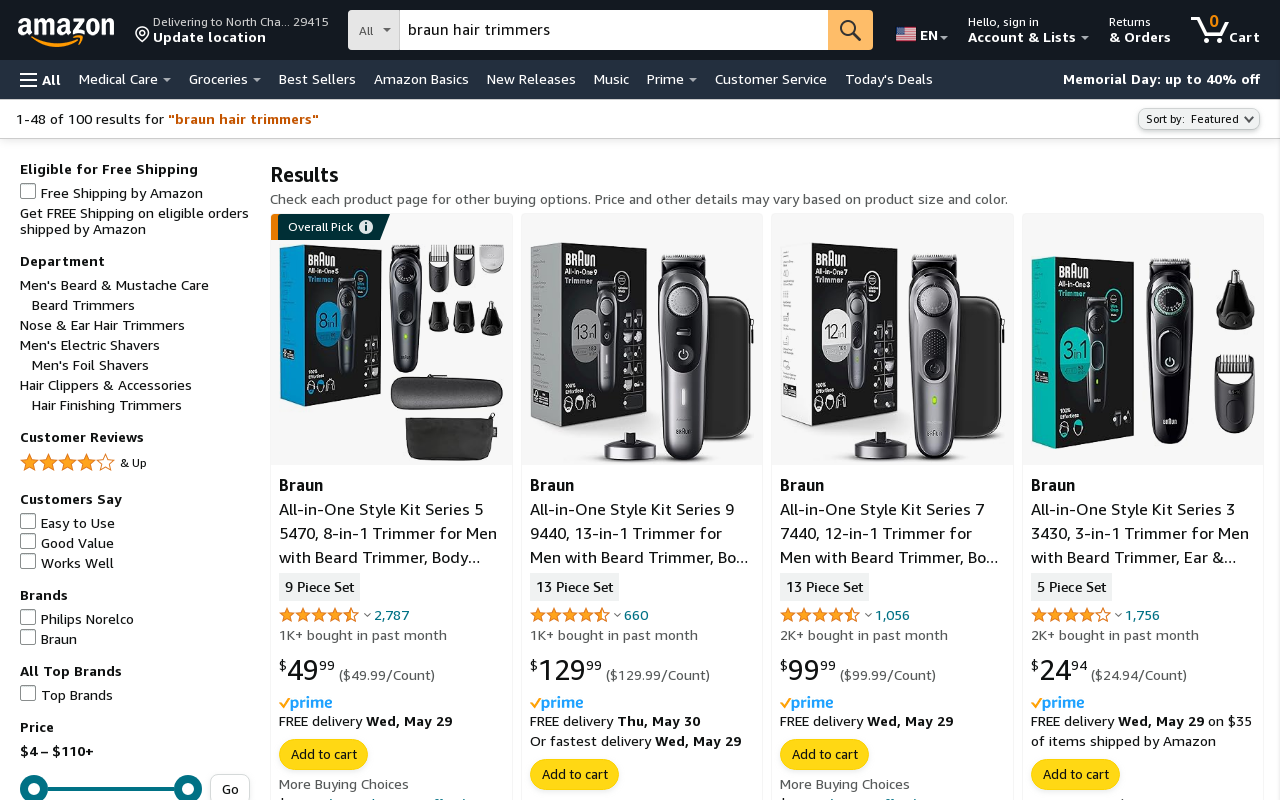

In [20]:
# Test the product search tool
ws_endpoint, screenshot = await product_search_tool.ainvoke({"product": "braun hair trimmers"})

print(ws_endpoint, screenshot, sep="\n")

Image(screenshot)

In [21]:
def products_list_function(screenshot: str):
    """use vlm to read the screenshot and prompt gemini to list the product on
    the page, and their corresponding coordinates."""

    # make product links inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='productlink',
        confidence=5,
        overlap=5
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of product listings on Amazon.com.
                  Note the products featured in this image, and the order in
                  which they appear from left to right. Include the price of each
                  product after the name of the product. Do not make anything up.""",
            },
            {
                "type": "text",
                "text": """Given the following array of objects with keys, 'x',
                   'y', 'width', and 'height', you can deduce the coordinates for
                   the midpoint (x, y), width, and height of the bounding box
                   around each product listed in the image. The origin (0,0)
                   of the coordinate system is the top-left corner of the entire
                   image. Note the midpoint (x,y) of the bounding box coordinates
                   for the products.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object, containing the name, price
                   and corresponding midpoint (x,y) of each product in the image."""
            }

        ]
    )

    resp = llm.invoke([message])

    return resp.content

products_list_tool = StructuredTool.from_function(
    func=products_list_function,
    name="ProductsList",
    description="""use this function to get list the products featured in the
    screenshot and their coordinates""",
    handle_tool_error=True,
)

In [22]:
# Test the products list tool
products = products_list_tool.invoke({"screenshot": screenshot})

print(products)

'```json\n[\n  {\n    "name": "Braun All-in-One Style Kit Series 5 5470, 8-in-1 Trimmer for Men with Beard Trimmer, Body...",\n    "price": "$49.99",\n    "midpoint": {\n      "x": 123.5,\n      "y": 758.0\n    }\n  },\n  {\n    "name": "Braun All-in-One Style Kit Series 9 9440, 13-in-1 Trimmer for Men with Beard Trimmer, Bo...",\n    "price": "$129.99",\n    "midpoint": {\n      "x": 394.5,\n      "y": 383.5\n    }\n  },\n  {\n    "name": "Braun All-in-One Style Kit Series 7 7440, 12-in-1 Trimmer for Men with Beard Trimmer, Bo...",\n    "price": "$99.99",\n    "midpoint": {\n      "x": 641.5,\n      "y": 398.5\n    }\n  },\n  {\n    "name": "Braun All-in-One Style Kit Series 3 3430, 3-in-1 Trimmer for Men with Beard Trimmer, Ear &...",\n    "price": "$24.94",\n    "midpoint": {\n      "x": 892.5,\n      "y": 401.5\n    }\n  }\n]\n```'

In [23]:
def add_product_to_cart_function(screenshot: str):
    """use vlm to read the screenshot and prompt gemini to identify the
    coordinates of the "Add to Cart" button on the page."""

    # make button inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='button'
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of a product page on Amazon.com.
                  Note the buttons on this page that a user can interact with in
                  in order to buy the product.""",
            },
            {
                "type": "text",
                "text": """Given the following array of objects with keys, 'x',
                   'y', 'width', and 'height', you can deduce the coordinates for
                   the midpoint (x, y), width, and height of the bounding box
                   around the buttons in the image. The origin (0,0)
                   of the coordinate system is the top-left corner of the entire
                   image. Note the midpoint (x,y) of the bounding box coordinates
                   for the buttons.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object containing the x, y midpoint
                    coordinates of the bounding box around the "Add to Cart"
                    button in the image."""
            }

        ]
    )

    resp = llm.invoke([message])

    return resp.content

add_product_to_cart_tool = StructuredTool.from_function(
    func=add_product_to_cart_function,
    name="AddProductToCart",
    description="""use this function to identify the Add to Cart button in the
    screenshot and its coordinate""",
    handle_tool_error=True,
)

In [24]:
# Test the add_product_to_cart tool
coordinate = add_product_to_cart_tool.invoke({"screenshot": screenshot})

print(coordinate)

'```json\n[{"x": 1075.5, "y": 775.5, "width": 91.0, "height": 31.0}, {"x": 323.5, "y": 755.5, "width": 91.0, "height": 31.0}, {"x": 822.0, "y": 755.0, "width": 86.0, "height": 32.0}, {"x": 575.0, "y": 775.5, "width": 90.0, "height": 31.0}]\n```'

In [25]:
def go_to_cart_function(screenshot: str):
    """use vlm to read the screenshot and prompt gemini to identify the
    coordinates of the "Go to Cart" button on the page."""

    # Make button inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='button'
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of a page after a product
                  has been added to cart on Amazon.com.
                  Note the buttons on this page that a user can interact with
                  in order to buy the product.""",
            },
            {
                "type": "text",
                "text": """Given the following array of objects with keys, 'x',
                   'y', 'width', and 'height', you can deduce the coordinates for
                   the midpoint (x, y), width, and height of the bounding box
                   around the buttons in the image. The origin (0,0)
                   of the coordinate system is the top-left corner of the entire
                   image. Note the midpoint (x,y) of the bounding box coordinates
                   for the buttons.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object containing the x, y midpoint
                    coordinates of the bounding box around the "Go to Cart"
                    button in the image."""
            }

        ]
    )

    resp = llm.invoke([message])

    return resp.content

go_to_cart_tool = StructuredTool.from_function(
    func=go_to_cart_function,
    name="GoToCart",
    description="""use this function to identify the Go to Cart button in the
    screenshot and its coordinate""",
    handle_tool_error=True,
)

In [26]:
# Test the go_to_cart tool
coordinate = go_to_cart_tool.invoke({"screenshot": screenshot})

print(coordinate)

'```json\n{"x": 575.0, "y": 775.5}\n```'